# Genetic Tuner Tutorial

This notebook demonstrates how to use the `GeneticTuner` to find optimal hyperparameters for a TimeSeries Agent.

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from timeseries_agent.tuners.genetic import GeneticTuner
from timeseries_agent.api import load_agent
from timeseries_agent.utils.extras import plot_evolution_of_fitness_scores_across_generations, plot_average_diversity_scores_across_generations
import warnings
warnings.filterwarnings("ignore")

## 1. Get Synthetic Data

In [2]:
# Load data
df = pd.read_csv("https://raw.githubusercontent.com/datasets/global-temp/main/data/monthly.csv")
df = df[df['Source'] == 'gcag']
df = df[['Year', 'Mean']]
df['temperature'] = df['Mean']
df.drop(columns=['Mean'], inplace=True)

# Train test split
target_column = 'temperature'
df = df.head(1000)
last_n_test_rows = 100
train_data = df.iloc[:-last_n_test_rows]
test_data = df.tail(last_n_test_rows)

# Add lags
train_data['Lag1'] = train_data[target_column].shift(1)
train_data['Lag2'] = train_data[target_column].shift(2)
test_data['Lag1'] = test_data[target_column].shift(1)
test_data['Lag2'] = test_data[target_column].shift(2)

train_data = train_data.dropna(subset=['Lag1', 'Lag2'])
test_data = test_data.dropna(subset=['Lag1', 'Lag2'])

# Save data to dir
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
train_csv_path = os.path.join(DATA_DIR, 'global_temp_train.csv')
test_csv_path = os.path.join(DATA_DIR, 'global_temp_test.csv')
train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

## 2. Define Parameter Search Space

In [3]:
# Parameter grid to explore
params_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'lookback': [5, 10, 15],
    'hidden_layers': [
        [50, 50],
        [100, 100, 10],
        [200, 100, 50],
    ],
}

# Base parameters that will be the same for all models
base_params = {
    'csv_path': train_csv_path,
    'feature_cols': ['Lag1', 'Lag2', 'temperature'],
    'target_col': 'temperature',
    'env_kwargs': {
        'normalize_state': True,
        'test_size': 0.2
    },
    'agent_kwargs': {
        'agent_type': 'reinforce',
        'output_size': 3,
    },
    'trainer_kwargs': {
        'max_epochs': 10,
        'enable_checkpointing': True,
    }
}

# Genetic Algorithm Configuration
genetic_params = {
    'population_size': 5,               # Size of each generation's population
    'num_generations': 3,               # Number of generations to evolve
    'mutation_rate': 0.1,               # Probability of parameter mutation
    'elitism_count': 1,                 # Number of best individuals to preserve
    'initial_temperature': 100.0,       # Initial temperature for simulated annealing
    'cooling_rate': 0.95,               # Rate at which temperature decreases
}

## 3. Run Genetic Tuner

In [4]:
# Create genetic tuner instance
tuner = GeneticTuner(
    base_log_dir="logs/genetic_tuning",
    **genetic_params
)

# Train models using genetic algorithm optimization
results = tuner.train(
    params_grid=params_grid,
    base_params=base_params,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode



Generation 1/3

Evaluating model 1/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3735632300376892     │
│          val_f1           │     0.41632279753685      │
│       val_precision       │    0.4757562577724457     │
│        val_recall         │    0.3735632300376892     │
│        val_reward         │   -0.25384995341300964    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

Evaluating model 2/5
Parameters: {'learning_rate': 0.0001, 'lookback': 15, 'hidden_layers': [100, 100, 10]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 15.7 K | train
-----------------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.37195122241973877    │
│          val_f1           │    0.4265214800834656     │
│       val_precision       │    0.49986231327056885    │
│        val_recall         │    0.37195122241973877    │
│        val_reward         │    -0.2552797794342041    │
│         val_steps         │           164.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]

Evaluating model 3/5
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [100, 100, 10]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 12.7 K | train
-----------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3218390941619873     │
│          val_f1           │    0.3778802156448364     │
│       val_precision       │     0.461709201335907     │
│        val_recall         │    0.3218390941619873     │
│        val_reward         │     -0.35643270611763     │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]

Evaluating model 4/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 12.7 K | train
-----------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3563218414783478     │
│          val_f1           │    0.43018418550491333    │
│       val_precision       │    0.5545454621315002     │
│        val_recall         │    0.3563218414783478     │
│        val_reward         │   -0.28666090965270996    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

Evaluating model 5/5
Parameters: {'learning_rate': 0.0005, 'lookback': 15, 'hidden_layers': [200, 100, 50]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 34.5 K | train
-----------------------------------------------------
34.5 K    Trainable params
0         Non-trainable params
34.5 K    Total params
0.138     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.28658536076545715    │
│          val_f1           │    0.3643490672111511     │
│       val_precision       │    0.5003235340118408     │
│        val_recall         │    0.28658536076545715    │
│        val_reward         │    -0.4270337224006653    │
│         val_steps         │           164.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]

Generation 2/3

Evaluating model 1/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.27586206793785095    │
│          val_f1           │     0.331063836812973     │
│       val_precision       │    0.41534388065338135    │
│        val_recall         │    0.27586206793785095    │
│        val_reward         │   -0.44994768500328064    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]

Evaluating model 2/5
Parameters: {'learning_rate': 0.0001, 'lookback': 15, 'hidden_layers': [100, 100, 10]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 15.7 K | train
-----------------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3231707215309143     │
│          val_f1           │    0.4059176445007324     │
│       val_precision       │    0.5457420945167542     │
│        val_recall         │    0.3231707215309143     │
│        val_reward         │    -0.352927565574646     │
│         val_steps         │           164.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode




Evaluating model 3/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3735632300376892     │
│          val_f1           │    0.4357426166534424     │
│       val_precision       │    0.5234680771827698     │
│        val_recall         │    0.3735632300376892     │
│        val_reward         │    -0.2524784803390503    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

Evaluating model 4/5
Parameters: {'learning_rate': 0.0005, 'lookback': 15, 'hidden_layers': [200, 100, 50]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 34.5 K | train
-----------------------------------------------------
34.5 K    Trainable params
0         Non-trainable params
34.5 K    Total params
0.138     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3109756112098694     │
│          val_f1           │    0.37621432542800903    │
│       val_precision       │    0.47643598914146423    │
│        val_recall         │    0.3109756112098694     │
│        val_reward         │    -0.3779551386833191    │
│         val_steps         │           164.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]

Evaluating model 5/5
Parameters: {'learning_rate': 0.0001, 'lookback': 15, 'hidden_layers': [100, 100, 10]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 15.7 K | train
-----------------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.31707316637039185    │
│          val_f1           │    0.3873274624347687     │
│       val_precision       │            0.5            │
│        val_recall         │    0.31707316637039185    │
│        val_reward         │    -0.3658536672592163    │
│         val_steps         │           164.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]

GPU available: False, used: False




Generation 3/3

Evaluating model 1/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.32758620381355286    │
│          val_f1           │    0.38666167855262756    │
│       val_precision       │    0.48061227798461914    │
│        val_recall         │    0.32758620381355286    │
│        val_reward         │    -0.3445466160774231    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]

Evaluating model 2/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.32758620381355286    │
│          val_f1           │    0.3945147693157196     │
│       val_precision       │    0.5227518677711487     │
│        val_recall         │    0.32758620381355286    │
│        val_reward         │    -0.345013827085495     │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 15.7 K | train
-----------------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode




Evaluating model 3/5
Parameters: {'learning_rate': 0.0001, 'lookback': 15, 'hidden_layers': [100, 100, 10]}
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.28658536076545715    │
│          val_f1           │    0.3559682071208954     │
│       val_precision       │    0.4699806869029999     │
│        val_recall         │    0.28658536076545715    │
│        val_reward         │   -0.42683956027030945    │
│         val_steps         │           164.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]

Evaluating model 4/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.270114928483963     │
│          val_f1           │    0.34859544038772583    │
│       val_precision       │    0.4922221899032593     │
│        val_recall         │     0.270114928483963     │
│        val_reward         │   -0.45890459418296814    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | policy_net    | Sequential | 3.5 K  | train
-----------------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode




Evaluating model 5/5
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [50, 50]}
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3218390941619873     │
│          val_f1           │     0.396703839302063     │
│       val_precision       │    0.5191766619682312     │
│        val_recall         │    0.3218390941619873     │
│        val_reward         │    -0.3552539348602295    │
│         val_steps         │           174.0           │
└───────────────────────────┴───────────────────────────┘

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]

Tuning results saved to: c:\Users\Collins P. Ohagwu\Desktop\pypi_projects\timeseries_agent\examples\logs\genetic_tuning\genetic_tuning_results_v0.csv


## 4. Analyze Results

In [5]:
display(results.head())

best_model = results.iloc[0]
print("Best Model Configuration:")
for param, value in best_model.items():
    print(f"{param}: {value}")

,learning_rate,lookback,hidden_layers,val_reward,val_accuracy,model_dir,fitness,generation,diversity_score
7,0.0010,5,"[50, 50]",-0.252478,0.373563,logs\genetic/gen_1_model_2\version_0,-0.094317,1,0.750000
0,0.0010,5,"[50, 50]",-0.253850,0.373563,logs\genetic/gen_0_model_0\version_0,-0.094829,0,0.750000
1,0.0001,15,"[100, 100, 10]",-0.255280,0.371951,logs\genetic/gen_0_model_1\version_0,-0.094952,0,0.666667
3,0.0010,5,"[100, 100, 10]",-0.286661,0.356322,logs\genetic/gen_0_model_3\version_0,-0.102144,0,0.583333
10,0.0010,5,"[50, 50]",-0.344547,0.327586,logs\genetic/gen_2_model_0\version_0,-0.112869,2,0.250000


Best Model Configuration:
learning_rate: 0.001
lookback: 5
hidden_layers: [50, 50]
val_reward: -0.2524784803390503
val_accuracy: 0.3735632300376892
model_dir: logs\genetic/gen_1_model_2\version_0
fitness: -0.09431667663046284
generation: 1
diversity_score: 0.75


### 4.a. Visualize Evolution

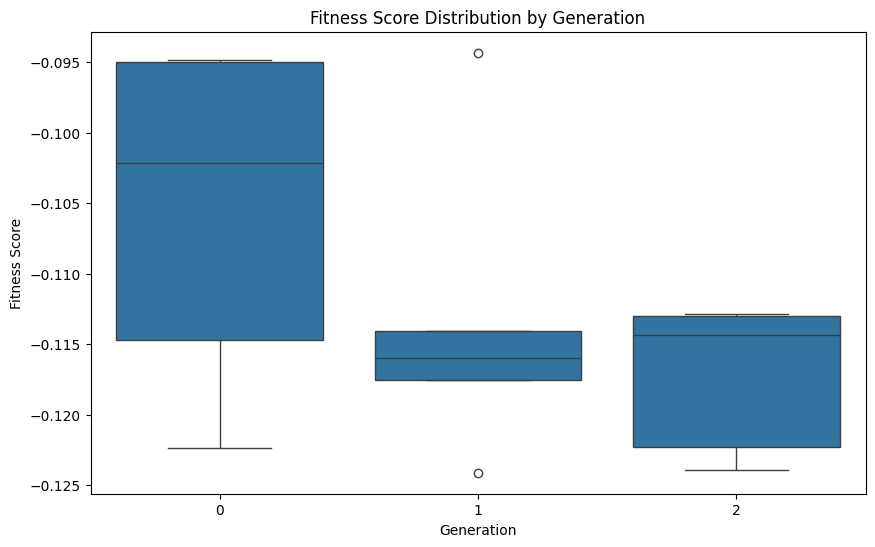

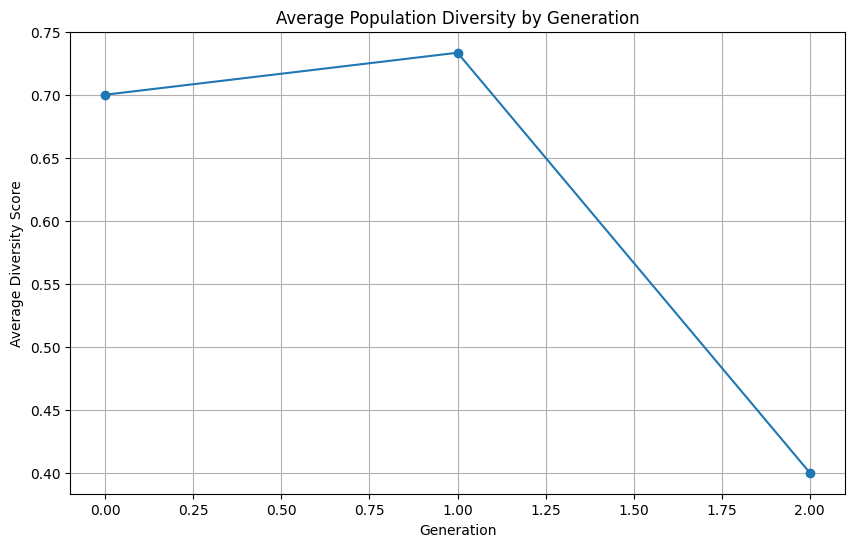

In [6]:
plot_evolution_of_fitness_scores_across_generations(results)
plot_average_diversity_scores_across_generations(results)

## 5. Evaluate Best Model

In [7]:
best_model_params = tuner.best_model_params
best_model_checkpoint = tuner.best_model_checkpoint

env_kwargs = base_params['env_kwargs']
env_kwargs['lookback'] = best_model_params['lookback']

loaded_agent = load_agent(
    checkpoint_path=best_model_checkpoint,
    csv_path=test_csv_path,
    feature_cols=base_params['feature_cols'],
    target_col=base_params['target_col'],
    agent_type='reinforce_step',
    **env_kwargs
)

def get_true_action(current_val, next_val):
    true_action = 0 if next_val > current_val else 1 if next_val < current_val else 2
    return true_action

def get_batch_predictions(df, lookback_size):
    predictions = []
    true_actions = []
    for i in range(lookback_size, len(df)):
        if i >= len(df) - 1:
            continue
        current_features = df[base_params['feature_cols']].iloc[i-lookback_size:i].values.astype(np.float32)
        current_target = df[base_params['target_col']].iloc[i]
        pred_action, probs = loaded_agent.act(current_features, return_probs=True)
        predictions.append(pred_action)
        next_target = df[base_params['target_col']].iloc[i+1]
        true_action = get_true_action(current_target, next_target)
        true_actions.append(true_action)
    return true_actions, predictions

df_test = pd.read_csv(test_csv_path)
y_true, y_pred = get_batch_predictions(df_test, best_model_params['lookback'])
print(f'\n true dist == {Counter(y_true)}, pred dist == {Counter(y_pred)}')


 true dist == Counter({0: 48, 1: 44}), pred dist == Counter({0: 39, 2: 27, 1: 26})
